In [ ]:
!pip install emoji
!pip install stop-words

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32894 sha256=fbc18c887e31809d834dbbf9923d81ab41e1226da6a52d8ecf1711716b6b0e0f
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import emoji
import string
from nltk.corpus import stopwords
from stop_words import get_stop_words
import nltk

nltk.download('punkt')
nltk.download('stopwords')
tqdm.pandas()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dfb = pd.read_csv('bengali_dataset.csv')
dfb = dfb.drop_duplicates(subset='text').reset_index(drop=True)
dfb

,text,label
0,আমি মনে করি যখন মেয়েরা উদ্দেশ্য অনুসারে বোবা ...,1.0
1,আমি যখন কোনও গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা করি ...,1.0
2,বাহ ... আমি দেখতে দেখতে পাচ্ছি সত্যিই দোষী দোষ...,1.0
3,"হাহ, মজার বিষয়।#আনোয়েড #গ্রুআপ",1.0
4,থান্ডার আমাকে 830 এ জেগে উঠলে এটি ভালবাসুন,1.0
...,...,...
6395,হইতে কতক্ষন গুজব সত্যি,0.0
6396,জন্য প্ররোচার করার সত্যতা ধন্যবাদ।,0.0
6397,বুঝিয়ে কে কোনো ছেলেদের না হয় দুঃখজনক 😪😪 বড়ই লাভ,0.0
6398,আগামীতে বাইকার আরো এই বাড়বে। সচেতন না। সাবধান ...,0.0


In [ ]:
dfh = pd.read_csv('hindi_dataset.csv')
dfh = dfh.drop_duplicates(subset='text').reset_index(drop=True)
dfh

,text,label
0,टम अन,1.0
1,रह hindi आपक इधर कल आक धन यव गल पय आए सत north...,1.0
2,something नत रखत यन maybe like quite this,1.0
3,रह hindi शब इसल आय जर english तग रस अरब सन com...,1.0
4,शब अलग कह नह दर speak लग वन भर language ever h...,1.0
...,...,...
5995,aur fun blessings missyou laana back happy har...,0.0
5996,बख aapkejazbaat bajrangautam आत दरव bajrangbha...,0.0
5997,कम ऐस करत लगत सब इव happy सहत पस मर लड lingerie,0.0
5998,love beautiful fashion devotion trending गल शन...,0.0


In [ ]:
bangla_stopwords=["অতএব","অথচ","অথবা","অনুযায়ী","অনেক","অনেকে","অনেকেই","অন্তত","অন্য","অবধি","অবশ্য","অর্থাত","আই","আগামী","আগে",
                  "আগেই","আছে","আজ","আদ্যভাগে","আপনার","আপনি","আবার","আমরা","আমাকে","আমাদের","আমার","আমি","আর","আরও",
                  "ই","ইত্যাদি","ইহা","উচিত","উত্তর","উনি","উপর","উপরে","এ","এঁদের","এঁরা","এই","একই","একটি","একবার","একে","এক্","এখন",
                  "এখনও","এখানে","এখানেই","এটা","এটাই","এটি","এত","এতটাই","এতে","এদের","এব","এবং","এবার","এমন","এমনকী","এমনি","এর",
                  "এরা","এল","এস","এসে","ঐ","ও","ওঁদের","ওঁর","ওঁরা","ওই","ওকে","ওখানে","ওদের","ওর","ওরা","কখনও","কত","কবে","কমনে",
                  "কয়েক","কয়েকটি","করছে","করছেন","করতে","করবে","করবেন","করলে","করলেন","করা","করাই","করায়","করার","করি","করিতে","করিয়া",
                  "করিয়ে","করে","করেই","করেছিলেন","করেছে","করেছেন","করেন","কাউকে","কাছ","কাছে","কাজ","কাজে","কারও","কারণ","কি","কিংবা","কিছু",
                  "কিছুই","কিন্তু","কী","কে","কেউ","কেউই","কেখা","কেন","কোটি","কোন","কোনও","কোনো","ক্ষেত্রে","কয়েক","খুব","গিয়ে","গিয়েছে","গিয়ে",
                  "গুলি","গেছে","গেল","গেলে","গোটা","চলে","চান","চায়","চার","চালু","চেয়ে","চেষ্টা","ছাড়া","ছাড়াও","ছিল","ছিলেন","জন","জনকে","জনের",
                  "জন্য","জন্যওজে","জানতে","জানা","জানানো","জানায়","জানিয়ে","জানিয়েছে","জে","জ্নজন","টি","ঠিক","তখন","তত","তথা","তবু","তবে",
                  "তা","তাঁকে","তাঁদের","তাঁর","তাঁরা","তাঁাহারা","তাই","তাও","তাকে","তাতে","তাদের","তার","তারপর","তারা","তারৈ","তাহলে","তাহা","তাহাতে",
                  "তাহার","তিনঐ","তিনি","তিনিও","তুমি","তুলে","তেমন","তো","তোমার","থাকবে","থাকবেন","থাকা","থাকায়","থাকে","থাকেন","থেকে","থেকেই",
                  "থেকেও","দিকে","দিতে","দিন","দিয়ে","দিয়েছে","দিয়েছেন","দিলেন","দু","দুই","দুটি","দুটো","দেওয়া","দেওয়ার","দেওয়া","দেখতে","দেখা","দেখে",
                  "দেন","দেয়","দ্বারা","ধরা","ধরে","ধামার","নতুন","নয়","না","নাই","নাকি","নাগাদ","নানা","নিজে","নিজেই","নিজেদের","নিজের","নিতে","নিয়ে",
                  "নিয়ে","নেই","নেওয়া","নেওয়ার","নেওয়া","নয়","পক্ষে","পর","পরে","পরেই","পরেও","পর্যন্ত","পাওয়া","পাচ","পারি","পারে","পারেন","পি","পেয়ে",
                  "পেয়্র্","প্রতি","প্রথম","প্রভৃতি","প্রযন্ত","প্রাথমিক","প্রায়","প্রায়","ফলে","ফিরে","ফের","বক্তব্য","বদলে","বন","বরং","বলতে","বলল","বললেন","বলা",
                  "বলে","বলেছেন","বলেন","বসে","বহু","বা","বাদে","বার","বি","বিনা","বিভিন্ন","বিশেষ","বিষয়টি","বেশ","বেশি","ব্যবহার","ব্যাপারে","ভাবে","ভাবেই",
                  "মতো","মতোই","মধ্যভাগে","মধ্যে","মধ্যেই","মধ্যেও","মনে","মাত্র","মাধ্যমে","মোট","মোটেই","যখন","যত","যতটা","যথেষ্ট","যদি","যদিও","যা","যাঁর",
                  "যাঁরা","যাওয়া","যাওয়ার","যাওয়া","যাকে","যাচ্ছে","যাতে","যাদের","যান","যাবে","যায়","যার","যারা","যিনি","যে","যেখানে","যেতে","যেন","যেমন","র",
                  "রকম","রয়েছে","রাখা","রেখে","লক্ষ","শুধু","শুরু","সঙ্গে","সঙ্গেও","সব","সবার","সমস্ত","সম্প্রতি","সহ","সহিত","সাধারণ","সামনে","সি","সুতরাং","সে",
                  "সেই","সেখান","সেখানে","সেটা","সেটাই","সেটাও","সেটি","স্পষ্ট","স্বয়ং","হইতে","হইবে","হইয়া","হওয়া","হওয়ায়","হওয়ার","হচ্ছে","হত","হতে","হতেই",
                  "হন","হবে","হবেন","হয়","হয়তো","হয়নি","হয়ে","হয়েই","হয়েছিল","হয়েছে","হয়েছেন","হল","হলে","হলেই","হলেও","হলো","হাজার","হিসাবে","হৈলে",
                  "হোক","হয়"]

hindi_stop_words = get_stop_words('hi')
english_stopwords= stopwords.words('english')

stopwords_set = set(english_stopwords + hindi_stop_words + bangla_stopwords)

In [ ]:
url_pattern = re.compile(r'((www\.[\S]+)|(https?://[\S]+))')
mention_pattern = re.compile(r'@\w+')
space_pattern = re.compile(r'\s+')
hashtag_pattern = re.compile(r'#(\w+)')


def process_text(text):
    text = text.lower()
    text = url_pattern.sub('', text)
    text = mention_pattern.sub('', text)
    text = space_pattern.sub(' ', text)
    text = hashtag_pattern.sub(r'\1', text)
    text = emoji.demojize(text)
    words=text.split()
    #tokenized_text = nltk.word_tokenize(text) # check if tokenisation here is needed as bert tokeniser is used later
    return ' '.join([word for word in words if word not in string.punctuation and word not in stopwords_set])


In [ ]:
tqdm.pandas()
dfb['text'] = dfb['text'].progress_apply(process_text)
dfb

  0%|          | 0/6400 [00:00<?, ?it/s]

,text,label
0,মেয়েরা উদ্দেশ্য অনুসারে বোবা বোবা আচরণ সুন্দর,1.0
1,গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা সত্যিই পছন্দ করি।...,1.0
2,বাহ ... পাচ্ছি সত্যিই দোষী দোষী সাব্যস্তনোটপ্রেসড,1.0
3,"হাহ, মজার বিষয়।আনোয়েড গ্রুআপ",1.0
4,থান্ডার 830 জেগে উঠলে ভালবাসুন,1.0
...,...,...
6395,কতক্ষন গুজব সত্যি,0.0
6396,প্ররোচার সত্যতা ধন্যবাদ।,0.0
6397,বুঝিয়ে ছেলেদের দুঃখজনক :sleepy_face::sleepy_fa...,0.0
6398,আগামীতে বাইকার আরো বাড়বে। সচেতন না। সাবধান হার...,0.0


In [ ]:
tqdm.pandas()
dfh['text'] = dfh['text'].progress_apply(process_text)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [ ]:
df = pd.concat([dfb, dfh], axis=0)

In [ ]:
label_counts = df['label'].value_counts()
print("Count of tweets with label 1.0 (sarcastic):", label_counts[1.0])
print("Count of tweets with label 0.0 (non-sarcastic):", label_counts[0.0])

Count of tweets with label 1.0 (sarcastic): 6200
Count of tweets with label 0.0 (non-sarcastic): 6200


In [ ]:
x_train_full, x_test, y_train_full, y_test = train_test_split(
    df['text'].tolist(), df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

# Convert labels to Series and reset index
y_train = pd.Series(y_train).reset_index(drop=True)
y_valid = pd.Series(y_valid).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Load IndicBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

# Define Dataset class for BERT
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=150,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create train, validation, and test datasets
train_dataset = SarcasmDataset(x_train, y_train)
valid_dataset = SarcasmDataset(x_valid, y_valid)
test_dataset = SarcasmDataset(x_test, y_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluation strategy
    save_strategy="epoch",  # Save strategy to match evaluation strategy
    learning_rate=1e-5,
    logging_dir="./logs",
    logging_steps=10,  # Log every 10 steps
    save_total_limit=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.1,
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for the best model
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # Stop training if validation loss does not improve for 2 evaluations
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.557400,0.363925
2,0.191000,0.245957
3,0.174000,0.266312
4,0.168700,0.175022
5,0.347000,0.242674
6,0.156100,0.339226


Accuracy Score: 0.946236559139785


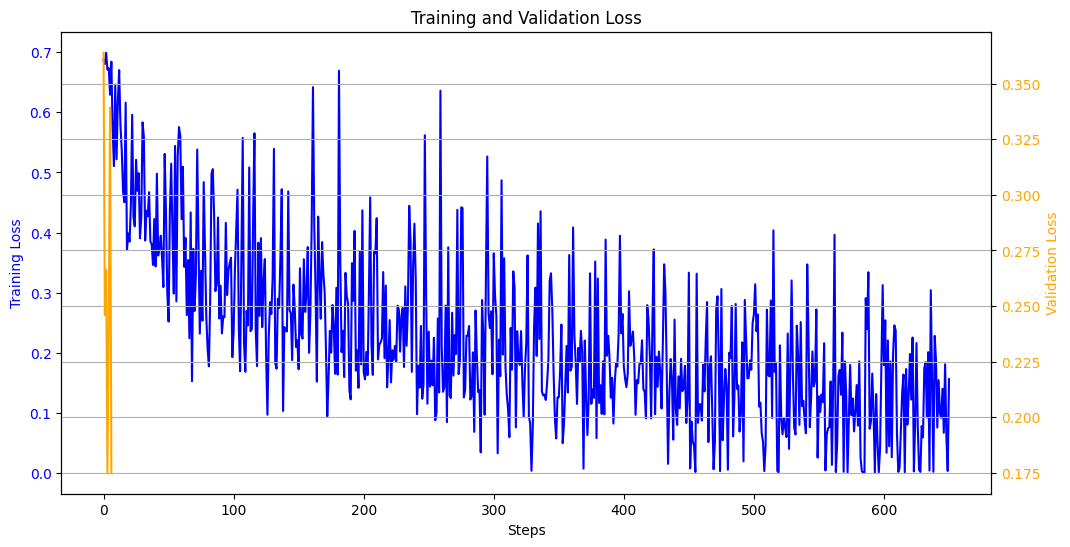

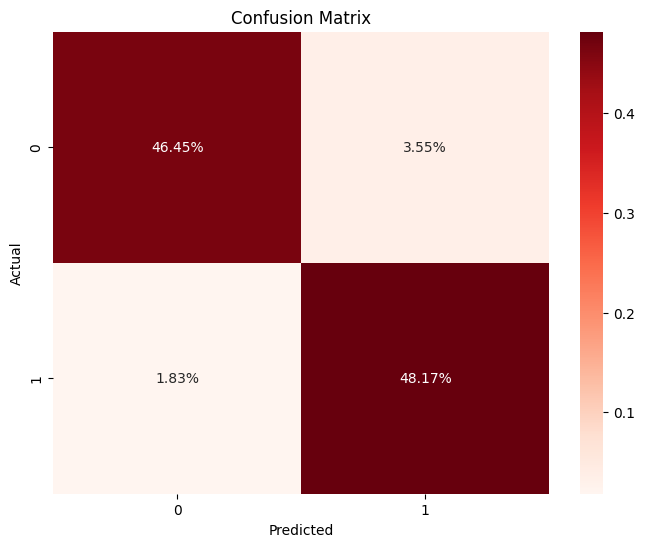

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      1860
         1.0       0.93      0.96      0.95      1860

    accuracy                           0.95      3720
   macro avg       0.95      0.95      0.95      3720
weighted avg       0.95      0.95      0.95      3720



In [ ]:
# Train the model
train_results = trainer.train()

# Extract training and validation losses
log_history = trainer.state.log_history
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
epochs = range(1, len(train_losses) + 1)

# Print training and validation losses per epoch
for epoch, (train_loss, eval_loss) in enumerate(zip(train_losses, eval_losses), start=1):
    print(f"Epoch {epoch}: Training Loss = {train_loss:.4f}, Validation Loss = {eval_loss:.4f}")

# Plot Training and Validation Loss vs. Epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", color="blue", marker="o")
plt.plot(epochs, eval_losses, label="Validation Loss", color="orange", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

# Final evaluation on the test set
test_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, predicted_labels))